In [9]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Problem : Principal Component Analysis
**Principal component analysis** (PCA) is a technique of dimensionality reduction, which linearly maps data onto a lower-dimensional space, so that the variance of the projected data in the associated dimensions would be maximized. In this problem, you will perform PCA on a dataset of face images.

### Ivy: 產生文字，但中間有變項數值的方法: {}.format(i,j)
###              'data/{}_{}.png'.format(i,j)

In [10]:
#There are 40 persons, each of whom has 10 pictures
#Train data: 1-9th pictures, 
#Test data: 10th picture

#Create data sets
X_train, X_test, Y_train, Y_test = [],[],[],[]

for i in range(1,41):
    #train data:1-9th
    for j in range(1,10):
        img = cv2.imread('data/{}_{}.png'.format(i,j), cv2.IMREAD_GRAYSCALE)
        X_train.append(img)
        Y_train.append(i)    #index as a person's id
    #test data: 10th
    img = cv2.imread('data/{}_10.png'.format(i,j), cv2.IMREAD_GRAYSCALE)
    X_test.append(img)
    Y_test.append(i)
    
X_train, X_test, Y_train, Y_test= np.array(X_train), np.array(X_test), np.array(Y_train), np.array(Y_test)
print(X_train.ndim, X_train.shape,'\n',\
      Y_train.ndim, Y_train.shape )
print(X_test.shape, Y_test.shape)


3 (360, 56, 46) 
 1 (360,)
(40, 56, 46) (40,)


In [11]:
#X_train 需要降dimension
x_train = X_train.reshape(len(Y_train), -1)
x_test = X_test.reshape(len(Y_test),-1)
print(x_train.shape)

#conclusion: ndarray (x) for each observation there are 2576 features.

(360, 2576)


## 1. mean face & first four eigenfaces

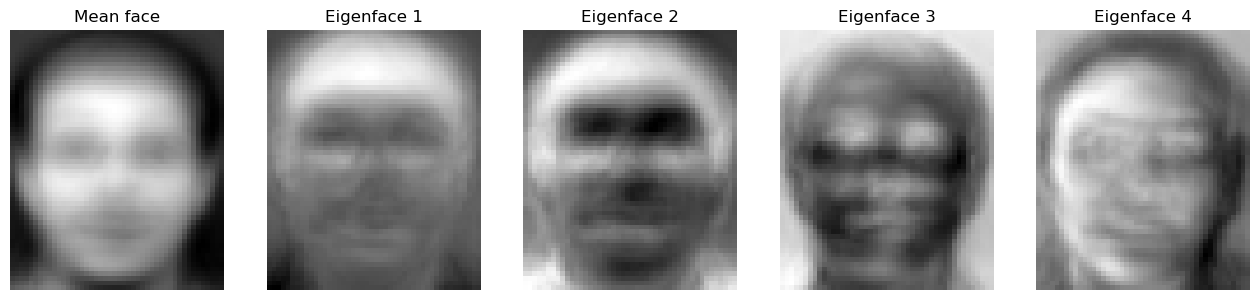

In [12]:
pca = PCA()
pca.fit(X_train.reshape(len(Y_train), -1))

plt.figure(figsize = (16,12))
plt.subplot(1,5,1)
plt.axis("off")
plt.title("Mean face")
plt.imshow(pca.mean_.reshape(X_train[0].shape), cmap = 'gray')

for i in range(4):
    plt.subplot(1,5,i+2)
    plt.axis("off")
    plt.title("Eigenface {}".format(i+1))
    plt.imshow(pca.components_[i].reshape(X_train[0].shape), cmap= 'gray')

#下面補充 pca.components_

In [13]:
#補充 pca.components_

print('type(pca.components_):',type(pca.components_),'\n', #ndarray\
     'dimension pca.components_:', pca.components_.ndim, '\n', #dimension\
      'shape pca.components_:',pca.components_.shape, '\n',\
      'pca.components_[0]:',
      'type(pca.components_[0]):',type(pca.components_[0]),'\n', #ndarray\
     'dimension pca.components_[0]:', pca.components_[0].ndim, '\n', #dimension\
      'shape pca.components_[0]:',pca.components_[0].shape, '\n')

#conclusion:
#pca.components_ 是二維，有360 張(筆)，每一張都是2576 features
#所以要呈現圖時，要reshape 回去原來的

type(pca.components_): <class 'numpy.ndarray'> 
 dimension pca.components_: 2 
 shape pca.components_: (360, 2576) 
 pca.components_[0]: type(pca.components_[0]): <class 'numpy.ndarray'> 
 dimension pca.components_[0]: 1 
 shape pca.components_[0]: (2576,) 



## 2. Reconstruct person2 image1 using the first n = 3, 50, 170, 240, 345 eigenfaces
## 3. compute the mean squared error

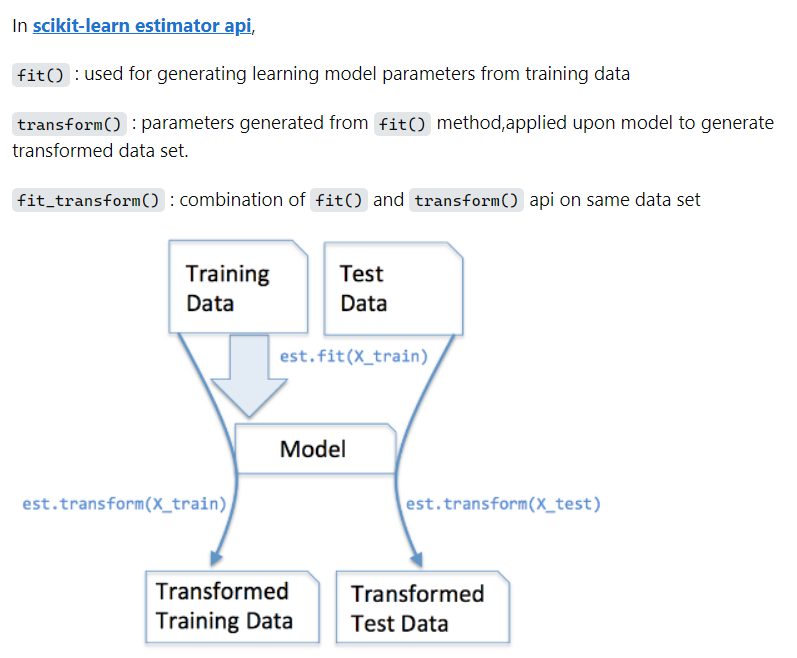

(360,) 1 360


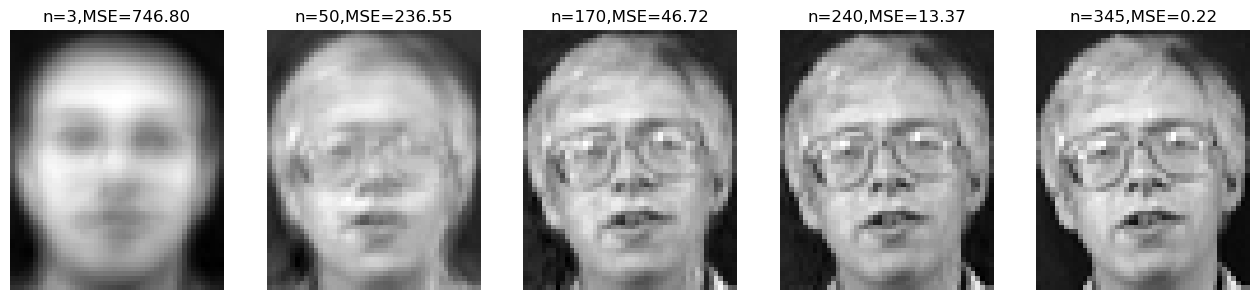

In [26]:
#Ivy notes: pca 已經訓練好了，看第二人的

img = cv2.imread('data/2_1.png', cv2.IMREAD_GRAYSCALE).reshape(1,-1)
a = pca.transform(img)

print(a[0].shape, a[0].ndim, len(a[0]))
 
 
plt.figure(figsize = (16,12))
n_components = [3,50,170,240,345]

for i,n in enumerate(n_components):
    face = np.zeros(img.shape)
    for j in range(n):
        face = face + a[0][j]*pca.components_[j]
    face = face + pca.mean_
    MSE = np.mean((face-img)**2)
    
    plt.subplot(1,5,i+1)
    plt.axis('off')
    plt.title("n={},MSE={:.2f}".format(n,MSE))
    plt.imshow(face.reshape(X_train[0].shape),cmap = 'gray')
    
    
     

## 4. cross-validation results

In [30]:
#補充 permutation

a = np.arange(10)
b = np.random.permutation(np.arange(10))
print(a)
print(b)

[0 1 2 3 4 5 6 7 8 9]
[6 9 4 2 0 7 5 8 1 3]


In [28]:
reduced_X_train = pca.transform(X_train.reshape(len(Y_train),-1))

K = [1, 3, 5]
N = [3, 50, 170]

random = np.random.permutation(len(Y_train))
reduced_X_train = reduced_X_train[random]
Y_train_random = Y_train[random]

for k in K:
    print('k={}'.format(k))
    knn = KNeighborsClassifier(n_neighbors = k)
    for n in N:
        print('   n = {}, '.format(n), end = '')
        score = cross_val_score(knn, reduced_X_train[:,:n], Y_train_random, cv=3)
        print('score={:.4f}'.format(score.mean()))

k=1
   n = 3, score=0.7250
   n = 50, score=0.9694
   n = 170, score=0.9667
k=3
   n = 3, score=0.6444
   n = 50, score=0.9139
   n = 170, score=0.9000
k=5
   n = 3, score=0.5972
   n = 50, score=0.8583
   n = 170, score=0.8389


## 5. recognition rate of the testing set

In [31]:
k = 1
n = 50

reduced_X_test = pca.transform(X_test.reshape(len(Y-test),-1))
knn = KNeighborsClassifier(n_neighbors = k)
knn.fit(reduced_X_train[:, :n], Y_train_random)
print('accuracy = {}'.format(knn.score(reduced_X_test[:,:n], Y_test)))

NameError: name 'Y' is not defined